In [1]:
import PIL
import numpy as np
import sys
import random
import torch
from torchvision import transforms
from torchvision.transforms import functional as ttf
import numbers
import cv2

import matplotlib.pyplot as plt
#-------------------------------------------------------------------------------


class RandomRotationFromSequence(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.choice(degrees)
        return angle

    def __call__(self, data):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        hr, lr = data
        angle = self.get_params(self.degrees)
        return ttf.rotate(hr, angle, self.resample, self.expand, self.center), \
                ttf.rotate(lr, angle, self.resample, self.expand, self.center)

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.hflip(hr), ttf.hflip(lr)
        return hr, lr

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.vflip(hr), ttf.vflip(lr)
        return hr, lr

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(data, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        hr, lr = data
        w, h = hr.size
        th, tw = output_size
        if w == tw or h == th:
            return 0, 0, h, w

        if w < tw or h < th:
            th, tw = h//2, w//2

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        hr, lr = data
        if self.padding > 0:
            hr = ttf.pad(hr, self.padding)
            lr = ttf.pad(lr, self.padding)

        i, j, h, w = self.get_params(data, self.size)
        return ttf.crop(hr, i, j, h, w), ttf.crop(lr, i, j, h, w)

class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, data):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        hr, lr = data
        return ttf.to_tensor(hr), ttf.to_tensor(lr)

class DataSampler:
    def __init__(self, img, sr_factor, crop_size):
        self.img = img
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        sizes = np.float32([x[0].size[0]*x[0].size[1] / float(img.size[0]*img.size[1]) \
            for x in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            RandomRotationFromSequence([0., 90., 180., 270.]),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomCrop(crop_size),
            ToTensor()])

    def create_hr_lr_pairs(self):
        smaller_side = min(self.img.size[0 : 2])
        larger_side = max(self.img.size[0 : 2])

        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = self.img.resize((int(self.img.size[0]*zoom), \
                                int(self.img.size[1]*zoom)), \
                resample=PIL.Image.BICUBIC)

            lr = hr.resize((int(hr.size[0]/self.sr_factor), \
                int(hr.size[1]/self.sr_factor)),
                resample=PIL.Image.BICUBIC)

            lr = lr.resize(hr.size, resample=PIL.Image.BICUBIC)

            pairs.append((hr, lr))

        return pairs

    def generate_data(self):
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            hr_tensor, lr_tensor = self.transform((hr, lr))
            hr_tensor = torch.unsqueeze(hr_tensor, 0)
            lr_tensor = torch.unsqueeze(lr_tensor, 0)
            yield hr_tensor, lr_tensor

UP_SCALE = 4
PATCH_SIZE = (128, 128)

img = PIL.Image.open("alligator.jpg")
sampler = DataSampler(img,
                        sr_factor=UP_SCALE,
                        crop_size=PATCH_SIZE)



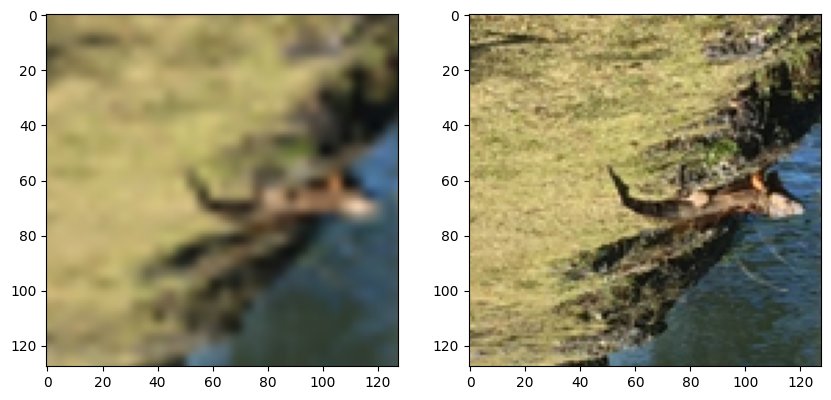

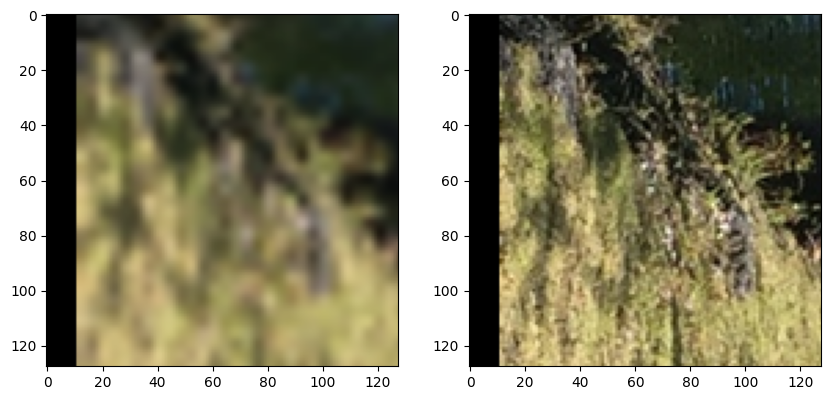

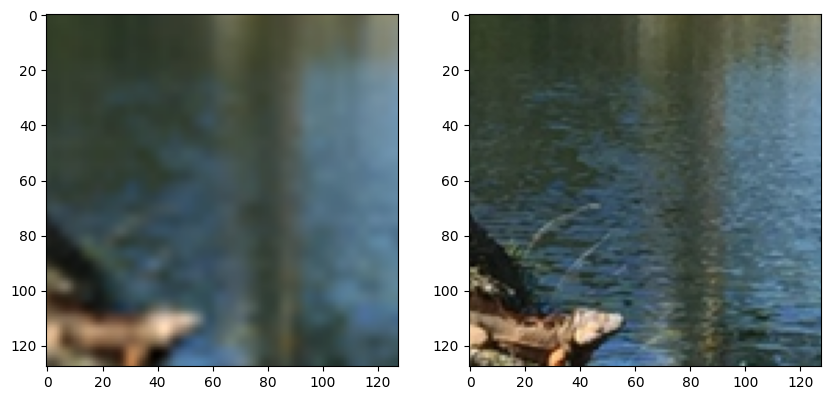

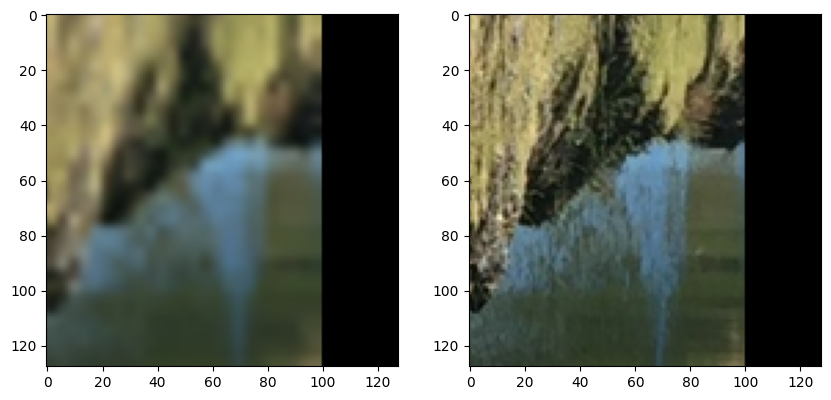

In [2]:
UP_SCALE = 4
PATCH_SIZE = (128, 128)

img = PIL.Image.open("alligator.jpg")
sampler = DataSampler(img,
                        sr_factor=UP_SCALE,
                        crop_size=PATCH_SIZE)


c = 0
for x in sampler.generate_data():
    hr, lr = x
    #hr = hr.numpy().transpose((1, 2, 0))
    #lr = lr.numpy().transpose((1, 2, 0))
    _, axs = plt.subplots(1, 2, figsize=(10,6))
    axs[0].imshow(ttf.to_pil_image(lr.squeeze()))
    axs[1].imshow(ttf.to_pil_image(hr.squeeze()))
    c +=1
    if c == 4:
        break

In [9]:
from torch.autograd import Variable
from tqdm import tqdm


def train(model, img, sr_factor=4, num_batches=100, learning_rate=0.0001, crop_size=(64,64)):
    loss = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    sampler = DataSampler(img, sr_factor, crop_size)
    model.cuda()
    with tqdm(total=num_batches, miniters=1, mininterval=0) as progress:
        for iter, (hr, lr) in enumerate(sampler.generate_data()):
            model.zero_grad()

            lr = Variable(lr).cuda()
            hr = Variable(hr).cuda()

            output = model(lr) + lr
            error = loss(output, hr)

            cpu_loss = error.data.cpu().numpy()

            progress.set_description("Iteration: {iter} Loss: {loss}, Learning Rate: {lr}".format( \
                iter=iter, loss=cpu_loss, lr=learning_rate))
            progress.update()

            if iter > 0 and iter % 10000 == 0:
                learning_rate = learning_rate / 10
                adjust_learning_rate(optimizer, new_lr=learning_rate)
                print("Learning rate reduced to {lr}".format(lr=learning_rate) )

            error.backward()
            optimizer.step()

            if iter == num_batches:
                print('Done training.')
                break

def test(model, img, sr_factor):
    model.eval()

    img = img.resize((int(img.size[0]*sr_factor), \
        int(img.size[1]*sr_factor)), resample=PIL.Image.BICUBIC)
    #img.save('low_res.png')

    with torch.no_grad():
        img = transforms.ToTensor()(img)
        img = torch.unsqueeze(img, 0)
        input = Variable(img.to(DEVICE))
        residual = model(input)
        output = input + residual

    output = output.cpu().data[0, :, :, :]
    o = output.numpy()
    o[np.where(o < 0)] = 0.0
    o[np.where(o > 1)] = 1.0
    output = torch.from_numpy(o)
    output = transforms.ToPILImage()(output)

    return output
    #output.save('zssr.png')


Iteration: 10 Loss: 0.03845959156751633, Learning Rate: 0.0001: : 11it [00:00, 25.48it/s]


Done training.


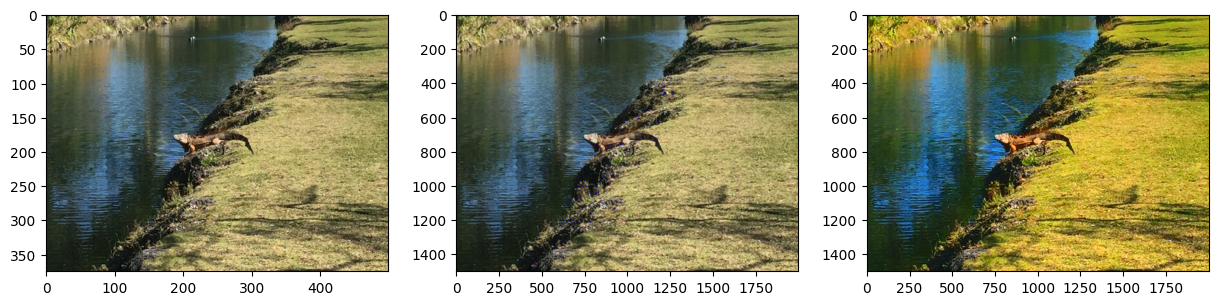

In [27]:
SRFACTOR = 4

from mrunet import *
DEVICE = "cuda:0"
#model = MRUNet(n_channels=3, n_resblocks=1, use_dropout=False).to(DEVICE)
train(model, img, sr_factor=SRFACTOR, num_batches=10, learning_rate=0.0001, crop_size=(64,64))
output = test(model, img, sr_factor = SRFACTOR)

_,axs = plt.subplots(1,3,figsize=(15,10))
axs[0].imshow(img)
axs[1].imshow(ttf.to_pil_image(
    F.interpolate(ttf.to_tensor(img).unsqueeze(0), scale_factor=SRFACTOR, mode="bicubic").squeeze())
)
axs[2].imshow(output)
plt.show()